# Semi empirical rudder forces

In [78]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
#%config Completer.use_jedi = False

In [38]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, track_plots, plot
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vmm_abkowitz_simplified import vmm
#from vessel_manoeuvring_models.models.vmm_abkowitz_expanded import abkowitz_model_expanded as vmm

from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.regression import Regression
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator
from vessel_manoeuvring_models.symbols import *
from vessel_manoeuvring_models.parameters import df_parameters
from vessel_manoeuvring_models.prime_system import PrimeSystem
from wPCC_pipeline.pipelines.vct_data.nodes import vct_scaling
p = df_parameters['symbol']
from vessel_manoeuvring_models.models.diff_eq_to_matrix import DiffEqToMatrix
from vessel_manoeuvring_models.substitute_dynamic_symbols import lambdify, run
import statsmodels.api as sm
import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('bmh')

from vct.bokeh_plotting import create_tab

## Load VCT data:

In [4]:
%reload_kedro
ship='wPCC'
time_series = catalog.load(f"{ship}.time_series")
df_VCT = catalog.load(f"{ship}.df_VCT")
ship_data = catalog.load(f"{ship}.ship_data")
df_VCT = vct_scaling(data=df_VCT, ship_data=ship_data)
df_VCT['U'] = df_VCT['V']
mask = df_VCT['model_name'].isin([
    'V2_3_R2',
])
df_VCT = df_VCT.loc[mask].copy()

thrust_keys = catalog.load(f"params:{ship}.thrust_keys")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ship}.time_series_meta_data")
time_series_meta_data.index = time_series_meta_data.index.astype(str)
time_series_meta_data.rename(columns={'test_type':'test type'}, inplace=True)

[05/30/23 17:06:16] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=361677;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=247841;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

                    WARNING  /home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/framew ]8;id=630314;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=966285;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             ork/startup.py:98: DeprecationWarning: project_version in                             
                             pyproject.toml is deprecated, use kedro_init_version instead                          
                               warnings.warn(                                                                      
                                                                                                                   

[05/30/23 17:06:17] INFO     Kedro project phd                                                      ]8;id=697972;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=447951;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=964273;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=561676;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=59595;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=798592;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from 'wPCC.time_series' (PartitionedDataSet)...       ]8;id=464274;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=954843;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.df_VCT' (CSVDataSet)...                    ]8;id=770279;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=55582;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=35355;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=459465;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:wPCC.thrust_keys' (MemoryDataSet)...     ]8;id=954170;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=205060;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:wPCC.exclude_parameters'                 ]8;id=62111;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=826521;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=990224;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=289537;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [5]:
df_rudder = df_VCT.groupby(by='test type').get_group('Rudder angle').sort_values(by='delta')

## Propeller

In [6]:
V_inf,V_A,C_Th,T,r_0,u,w_f,rho = sp.symbols('V_inf,V_A,C_Th,T,r_0,u,w_f,rho,')
eq_V_A = sp.Eq(V_A, (1-w_f)*u)
display(eq_V_A)
eq_V_inf = sp.Eq(V_inf, V_A*sp.sqrt(1+C_Th))
display(eq_V_inf)

Eq(V_A, u*(1 - w_f))

Eq(V_inf, V_A*sqrt(C_Th + 1))

In [8]:
eq_C_Th = sp.Eq(C_Th, T/(sp.Rational(1,2)*rho*V_A**2*sp.pi*(2*r_0)**2/4))
eq_C_Th

Eq(C_Th, 2*T/(pi*V_A**2*r_0**2*rho))

In [9]:
r_inf = sp.symbols('r_inf')
eq_r_inf = sp.Eq(r_inf, r_0*sp.sqrt(sp.Rational(1,2)*(1+V_A/V_inf)))
eq_r_inf

Eq(r_inf, r_0*sqrt(V_A/(2*V_inf) + 1/2))

In [10]:
r_p,x = sp.symbols('r_p,x')
eq_r = sp.Eq(r_p, r_0*(0.14*(r_inf/r_0)**3 + (r_inf/r_0)*(x/r_0)**1.5) / ((0.14*r_inf/r_0)**3 + (x/r_0)**1.5))
eq_r

Eq(r_p, r_0*(r_inf*(x/r_0)**1.5/r_0 + 0.14*r_inf**3/r_0**3)/((x/r_0)**1.5 + 0.002744*r_inf**3/r_0**3))

In [11]:
V_xp = sp.symbols('V_xp')
eq_Vxp = sp.Eq(V_xp, V_inf*(r_inf/r_p)**2)
eq_Vxp

Eq(V_xp, V_inf*r_inf**2/r_p**2)

In [12]:
r_Delta = sp.symbols('r_Delta')
eq_r_Delta = sp.Eq(r_Delta, 0.15*x*((V_xp-V_A)/(V_xp+V_A)))
eq_r_Delta

Eq(r_Delta, 0.15*x*(-V_A + V_xp)/(V_A + V_xp))

In [13]:
V_x = sp.symbols('V_x')
eq_V_x = sp.Eq(V_x, (V_xp-V_A)*r_p/(r_p+r_Delta) + V_A)
eq_V_x

Eq(V_x, V_A + r_p*(-V_A + V_xp)/(r_Delta + r_p))

## Rudder

In [14]:
u, v, w, p, q, r = sp.symbols('u v w p q r')
V_xR, V_yR, V_zR = sp.symbols('V_xr V_yr V_zr')
V_xWave, V_yWave, V_zWave = sp.symbols('V_xWave V_yWave V_zWave')
x_R, y_R, z_R = sp.symbols('x_R y_R z_R')
gamma = sp.symbols('gamma')

eq_V_xR_wave = sp.Eq(V_xR, V_x - V_xWave + q*z_R - r*y_R)
eq_V_yR_wave = sp.Eq(V_yR, -v + V_yWave - r*x_R + p*z_R)
eq_V_zR_wave = sp.Eq(V_zR, -w + V_zWave - q*y_R - q*x_R)

display(eq_V_xR_wave)
display(eq_V_yR_wave)
display(eq_V_zR_wave)


Eq(V_xr, V_x - V_xWave + q*z_R - r*y_R)

Eq(V_yr, V_yWave + p*z_R - r*x_R - v)

Eq(V_zr, V_zWave - q*x_R - q*y_R - w)

In [15]:
eq_V_xR = eq_V_xR_wave.subs(V_xWave,0)
eq_V_yR = eq_V_yR_wave.subs(V_yWave,0)
eq_V_zR = eq_V_zR_wave.subs(V_zWave,0)

display(eq_V_xR)
display(eq_V_yR)
display(eq_V_zR)

Eq(V_xr, V_x + q*z_R - r*y_R)

Eq(V_yr, p*z_R - r*x_R - v)

Eq(V_zr, -q*x_R - q*y_R - w)

In [16]:
eq_gamma = sp.Eq(gamma, sp.atan(V_yR/V_xR))
eq_gamma

Eq(gamma, atan(V_yr/V_xr))

In [17]:
V_R = sp.symbols('V_R')
eq_V_R = sp.Eq(V_R, sp.sqrt(V_xR**2+V_yR**2+V_zR**2))
eq_V_R

Eq(V_R, sqrt(V_xr**2 + V_yr**2 + V_zr**2))

In [18]:
A,A_g = sp.symbols('Lambda Lambda_g')
delta,delta_lim = sp.symbols('delta delta_lim')

In [19]:
L,D,C_L,C_D,A_R,b,kappa,C_L_tune = sp.symbols('L,D,C_L,C_D,A_R,b,kappa,C_L_tune')

In [20]:
eq_A_g = sp.Eq(A_g,b**2/A_R)
eq_A_g

Eq(Lambda_g, b**2/A_R)

In [21]:
eq_A = sp.Eq(A, A_g*(2-sp.Abs(delta/delta_lim)))
eq_A

Eq(Lambda, Lambda_g*(2 - Abs(delta/delta_lim)))

In [22]:
eq_L = sp.Eq(L, C_L_tune*1/2*rho*C_L*A_R*V_R**2)
eq_D = sp.Eq(D, 1/2*rho*C_D*A_R*V_R**2)
display(eq_L)
display(eq_D)

Eq(L, A_R*C_L*C_L_tune*V_R**2*rho/2)

Eq(D, 0.5*A_R*C_D*V_R**2*rho)

In [23]:
eq_C_L = sp.Eq(C_L, 2*sp.pi*A*(A+1)/(A+2)**2*sp.sin(delta+kappa*gamma))
eq_C_L

Eq(C_L, 2*pi*Lambda*(Lambda + 1)*sin(delta + gamma*kappa)/(Lambda + 2)**2)

In [24]:
eq_A.subs([
    (A_g,1.46),
    (delta_lim,np.deg2rad(35)),
    (delta,np.deg2rad(10))
])

Eq(Lambda, 2.50285714285714)

In [25]:
eq_C_L.subs([
    (gamma,0),
    (A,2.5),
    (delta,np.deg2rad(10)),
    (sp.pi,np.pi),
])

Eq(C_L, 0.471447268502936)

In [26]:
C_D0 = sp.symbols('C_D0')
eq_C_D = sp.Eq(C_D, 1.1*C_L**2/(sp.pi*A)+C_D0)
eq_C_D

Eq(C_D, C_D0 + 1.1*C_L**2/(pi*Lambda))

In [27]:
C_F,R_e = sp.symbols('C_F,R_e')
eq_C_D0 = sp.Eq(C_D0, 2.5*C_F)
eq_C_D0

Eq(C_D0, 2.5*C_F)

In [28]:
eq_CF = sp.Eq(C_F, 0.075/((sp.log(R_e)-2)**2))
eq_CF

Eq(C_F, 0.075/(log(R_e) - 2)**2)

In [29]:
kinematic_viscosity,c = sp.symbols('nu c')
eq_Re = sp.Eq(R_e, V_R*c/kinematic_viscosity)
eq_Re

Eq(R_e, V_R*c/nu)

In [66]:
lambdify_equations = [
eq_V_xR,
eq_V_yR,
eq_V_zR,
eq_gamma,
eq_V_R,
eq_A_g,
eq_A,
eq_C_L,
eq_Re,
eq_CF,
eq_C_D0,
eq_C_D,
eq_L,
eq_D,
]

lambdas_rudd = {eq.lhs:lambdify(eq.rhs) for eq in lambdify_equations}

In [77]:
lambdify_equations = [
eq_V_xR,
eq_V_yR,
eq_V_zR,
eq_gamma,
eq_V_R,
eq_A_g,
eq_A,
eq_C_L,
eq_Re,
eq_CF,
eq_C_D0,
eq_C_D,
eq_L,
eq_D,
]
sp.solve(lambdify_equations, L, )


[]

In [67]:
lambdify_equations_prop = [
eq_V_A,
eq_C_Th,
eq_V_inf,
eq_r_inf,
eq_r,   
eq_Vxp,
eq_r_Delta,
eq_V_x,
]


lambdas_prop = {eq.lhs:lambdify(eq.rhs) for eq in lambdify_equations_prop}

In [68]:
lambdas = {}
lambdas.update(lambdas_prop)
lambdas.update(lambdas_rudd)
               

## Calculation

In [36]:
df_rudder.head()

,level_0,Dp,S,S_Xgrid,S_inner_bracket_port,S_inner_bracket_stb,S_outer_bracket_port,S_outer_bracket_stb,S_rudder_port,S_rudder_stb,S_shaft_port_assembly,S_shaft_port_shaft1,S_shaft_port_shaft2,S_shaft_stb_assembly,S_shaft_stb_shaft1,S_shaft_stb_shaft2,V,beta,delta,fx,fx_Xgrid,fx_inner_bracket_port,fx_inner_bracket_stb,fx_outer_bracket_port,fx_outer_bracket_stb,fx_rudder_port,fx_rudder_stb,fx_shaft_port_assembly,fx_shaft_port_shaft1,fx_shaft_port_shaft2,fx_shaft_stb_assembly,fx_shaft_stb_shaft1,fx_shaft_stb_shaft2,fy,fy_Xgrid,fy_inner_bracket_port,fy_inner_bracket_stb,fy_outer_bracket_port,fy_outer_bracket_stb,fy_rudder_port,fy_rudder_stb,fy_shaft_port_assembly,fy_shaft_port_shaft1,fy_shaft_port_shaft2,fy_shaft_stb_assembly,fy_shaft_stb_shaft1,fy_shaft_stb_shaft2,fz,fz_Xgrid,fz_inner_bracket_port,fz_inner_bracket_stb,fz_outer_bracket_port,fz_outer_bracket_stb,fz_rudder_port,fz_rudder_stb,fz_shaft_port_assembly,fz_shaft_port_shaft1,fz_shaft_port_shaft2,fz_shaft_stb_assembly,fz_shaft_stb_shaft1,fz_shaft_stb_shaft2,g,lpp,mx,mx_Xgrid,mx_inner_bracket_port,mx_inner_bracket_stb,mx_outer_bracket_port,mx_outer_bracket_stb,mx_rudder_port,mx_rudder_stb,mx_shaft_port_assembly,mx_shaft_port_shaft1,mx_shaft_port_shaft2,mx_shaft_stb_assembly,mx_shaft_stb_shaft1,mx_shaft_stb_shaft2,my,my_Xgrid,my_inner_bracket_port,my_inner_bracket_stb,my_outer_bracket_port,my_outer_bracket_stb,my_rudder_port,my_rudder_stb,my_shaft_port_assembly,my_shaft_port_shaft1,my_shaft_port_shaft2,my_shaft_stb_assembly,my_shaft_stb_shaft1,my_shaft_stb_shaft2,mz,mz_Xgrid,mz_inner_bracket_port,mz_inner_bracket_stb,mz_outer_bracket_port,mz_outer_bracket_stb,mz_rudder_port,mz_rudder_stb,mz_shaft_port_assembly,mz_shaft_port_shaft1,mz_shaft_port_shaft2,mz_shaft_stb_assembly,mz_shaft_stb_shaft1,mz_shaft_stb_shaft2,r,result_file_path,rho,u,v,name,path,thrust,rev,p,phi,model_name,S_BK_port1,S_BK_stb1,fx_BK_port1,fx_BK_stb1,fy_BK_port1,fy_BK_stb1,fz_BK_port1,fz_BK_stb1,mx_BK_port1,mx_BK_stb1,my_BK_port1,my_BK_stb1,mz_BK_port1,mz_BK_stb1,S_daggerboard_middle,fx_daggerboard_middle,fy_daggerboard_middle,fz_daggerboard_middle,mx_daggerboard_middle,my_daggerboard_middle,mz_daggerboard_middle,S_R4083_ref,fx_R4083_ref,fy_R4083_ref,fz_R4083_ref,mx_R4083_ref,my_R4083_ref,mz_R4083_ref,S_Rudder_Center,S_Rudder_Port,S_Rudder_Starboard,S_hull,S_rudder,fx_Rudder_Center,fx_Rudder_Port,fx_Rudder_Starboard,fx_hull,fx_rudder,fy_Rudder_Center,fy_Rudder_Port,fy_Rudder_Starboard,fy_hull,fy_rudder,fz_Rudder_Center,fz_Rudder_Port,fz_Rudder_Starboard,fz_hull,fz_rudder,mx_Rudder_Center,mx_Rudder_Port,mx_Rudder_Starboard,mx_hull,mx_rudder,my_Rudder_Center,my_Rudder_Port,my_Rudder_Starboard,my_hull,my_rudder,mz_Rudder_Center,mz_Rudder_Port,mz_Rudder_Starboard,mz_hull,mz_rudder,torque,test type,eta0,eta0_round,fx_rudders,fy_rudders,fz_rudders,mx_rudders,my_rudders,mz_rudders,clr,S_daggerboard_port,S_daggerboard_stb,fake_index,fx_daggerboard_port,fx_daggerboard_stb,fy_daggerboard_port,fy_daggerboard_stb,fz_daggerboard_port,fz_daggerboard_stb,mx_daggerboard_port,mx_daggerboard_stb,my_daggerboard_port,my_daggerboard_stb,mz_daggerboard_port,mz_daggerboard_stb,$\frac{fx}{V^2}$,$\frac{fy}{V^2}$,$\frac{mz}{V^2}$,U
405,8,5.0,7503.769848,7080.407153,12.054919,12.054919,13.180297,13.180297,131.188033,130.387381,55.614190,32.207493,23.406809,55.709488,32.302491,23.406847,0.961690,0.0,-0.261799,-6.198123,-201971.984555,153.770571,1710.201950,-707.995534,333.168594,-111558.352806,-107261.882479,-7179.511010,-5523.862459,-1655.642690,-6979.036903,-5526.246579,-1452.800582,-19.640289,-60273.408479,-4049.478196,-20056.344771,24673.825459,-38055.040950,-608107.845907,-6.596621e+05,7771.269369,3675.905300,4095.350001,-15774.898792,-11492.706806,-4282.250454,-67.914772,-4.628090e+06,997.134557,-5178.819573,5800.439503,8986.759075,-46370.206052,-68356.635545,-7619.616224,-841.704334,-6777.907054,-9762.602514,-2702.114744,-7060.488210,9.80665,206.6,1.543622,-1.354087e+06,25627.935864,96407.410543,-25709.345856,30927.662495,2.05

<Axes: xlabel='delta', ylabel='fy_rudders'>

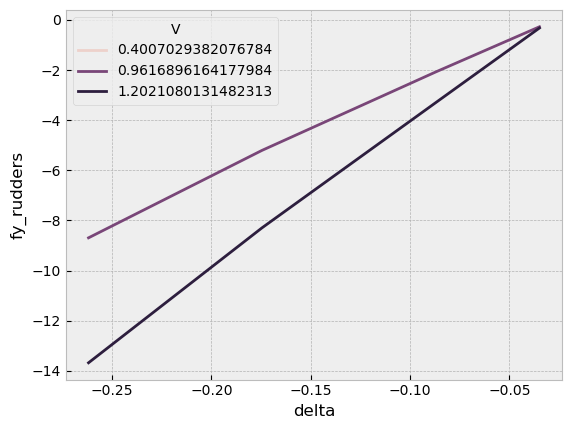

In [39]:
fig,ax=plt.subplots()

df_rudder = df_VCT.groupby('test type').get_group('Rudder angle').copy()
df_rudder.sort_values(by=['V','delta'], inplace=True)
sns.lineplot(df_rudder, x='delta', y='fy_rudders', hue='V')


<Axes: xlabel='delta', ylabel='fy_rudders'>

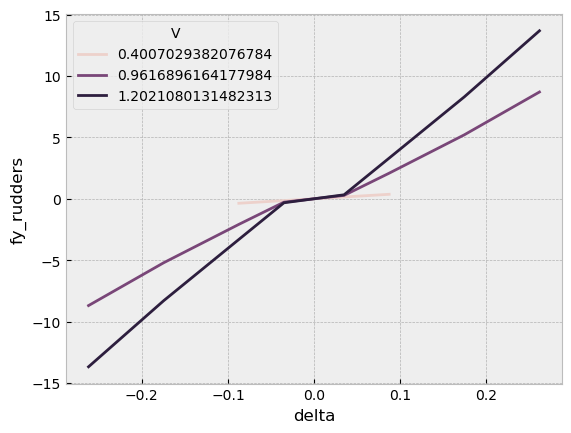

In [75]:
fig,ax=plt.subplots()
df_ = df_VCT.copy()
df_['delta']*=-1
df_['fy_rudders']*=-1
df_ = pd.concat((df_VCT, df_), axis=0)


df_rudder = df_.groupby('test type').get_group('Rudder angle').copy()
df_rudder.sort_values(by=['V','delta'], inplace=True)
sns.lineplot(df_rudder, x='delta', y='fy_rudders', hue='V')

In [40]:
#def remove_old_rudder_forces(df):
#    df = df.copy()
#    
#    for dof in ['fx','fy','fz','mx','my','mz']:
#        key = f"{dof}_rudder_port"
#        df[dof]-=df[key]
#    
#        key = f"{dof}_rudder_stb"
#        df[dof]-=df[key]
#        
#    return df

In [41]:
#df = df_VCT.groupby('test type').get_group('Rudder angle')
#df = remove_old_rudder_forces(df=df)
#df_star_VCT = pd.merge(left=df_star, right=df, how='inner', left_on='delta', right_on='delta', suffixes=('','_vct'))
#for dof in ['fx','fy','mz']:
#    df_star_VCT[dof]+=df_star_VCT[f'{dof}_vct']
#

In [45]:
ship_data

{'T': 0.2063106796116504,
 'L': 5.014563106796117,
 'CB': 0.45034232324249973,
 'B': 0.9466019417475728,
 'rho': 1000,
 'x_G': 0,
 'm': 441.0267843660858,
 'I_z': 693.124396594905,
 'volume': 0.4410267843660858,
 'scale_factor': 41.2,
 'x_r': -2.42219908951329,
 'TWIN': 1,
 'x_p': -2.42219908951329,
 'D': 0.12135922330097086,
 'w_p0': 0.151,
 'n_prop': 2}

In [55]:
prop_data = {
'wffix' : ship_data['w_p0'],
'D':ship_data['D'],
}

rudder_particulars = {
'x_R' : ship_data['x_r'],
'y_R' : 0,
'z_R' : 0,
'A_R' : 70/(ship_data['scale_factor']**2),
'rh'  : 7.18/ship_data['scale_factor']

}

In [65]:
lambdas[V_A]

<function _lambdifygenerated(V_A, u, w_f)>

In [71]:
def replace_with_semiempirical_rudder(df_VCT, x_:float=2.05, C_L_tune_=1.0, thrust_key: str='thrust'):
    
    ## Removeing old rudder forces:
    #df = remove_old_rudder_forces(df=df_VCT)
    df = df_VCT.copy()
    
    df['q'] = 0
    df['w'] = 0
    df['w_f'] = prop_data['wffix']
    
    df['T'] = df[thrust_key]
    df['r_0'] = prop_data['D']/2
    df['x'] = x_
    
    #df['V_x'] = df['u']  # propeller induced speed...
    df['x_R'] = rudder_particulars['x_R']
    df['y_R'] = rudder_particulars['y_R']
    df['z_R'] = rudder_particulars['z_R']
    
    df['A_R'] = rudder_particulars['A_R']
    df['C_L_tune'] = C_L_tune_
    df['b'] = rudder_particulars['rh']
    
    df['delta_lim'] = np.deg2rad(35)
    df['c'] = df['A_R']/df['b']
    df['nu'] = 1.18849E-06
    df['kappa'] = 0.3  # Flow straightening (0 is straigthened flow --> angle of attack=delta)
    
    for symbol, function in lambdas.items():
        
        key = str(symbol)
        assert key not in df, f"key:{key} has already a value!"
        try:
            df[key] = run(function=function, inputs=df)
        except Exception as e:
            raise ValueError(f"Failed in: {key}")
        
    n_rud = ship_data['n_prop']
    
    
    fy_rudders = n_rud*df['L']
    df['fy']+= -df['fy_rudders'] + fy_rudders
    df['fx']+= df['fx_rudders'] - n_rud*df['D']
    df['mz']+= -df['mz_rudders'] + df['x_R']*fy_rudders
    df['fy_rudders'] = fy_rudders
    
    df['delta_deg'] = np.rad2deg(df['delta'])
    
    return df

In [72]:
C_L_tune_=1.0
thrust_key = 'thrust'
df = replace_with_semiempirical_rudder(df_VCT=df_rudder, C_L_tune_=C_L_tune_, thrust_key=thrust_key)

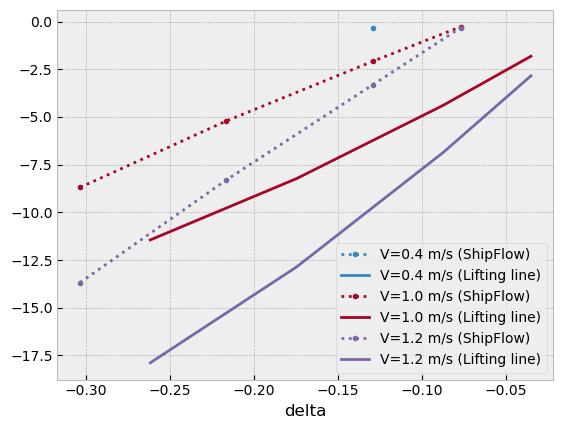

In [73]:
fig,ax=plt.subplots()

df_rudder = df_VCT.groupby('test type').get_group('Rudder angle').copy()
df_rudder.sort_values(by=['V','delta'], inplace=True)
d_delta=np.deg2rad(-2.4)
df_rudder['delta']+=d_delta

df_rudder.sort_values(by=['V','delta'], inplace=True)

prediction_groups = df.groupby(by='V', sort=False)

key = 'fy_rudders'
#key = 'fy'
for V_, group in df_rudder.groupby(by='V', sort=False):
    plot = group.plot(x='delta', y=key, label=f'V={np.round(V_,1)} m/s (ShipFlow)', style='.:', ax=ax)
    color = plot.lines[-1].get_color()
    prediction_groups.get_group(V_).plot(x='delta', y=key, label=f'V={np.round(V_,1)} m/s (Lifting line)', color=color, style='-', ax=ax)


In [39]:
df_thrust_variation = df_VCT.groupby('test type').get_group('Thrust variation').copy()
df_thrust_variation.sort_values(by=['V','thrust'], inplace=True)
d_delta=np.deg2rad(-2.4)
df_thrust_variation['delta']+=d_delta

In [40]:
df2 = replace_with_semiempirical_rudder(df_VCT=df_thrust_variation, C_L_tune_=C_L_tune_, thrust_key=thrust_key)

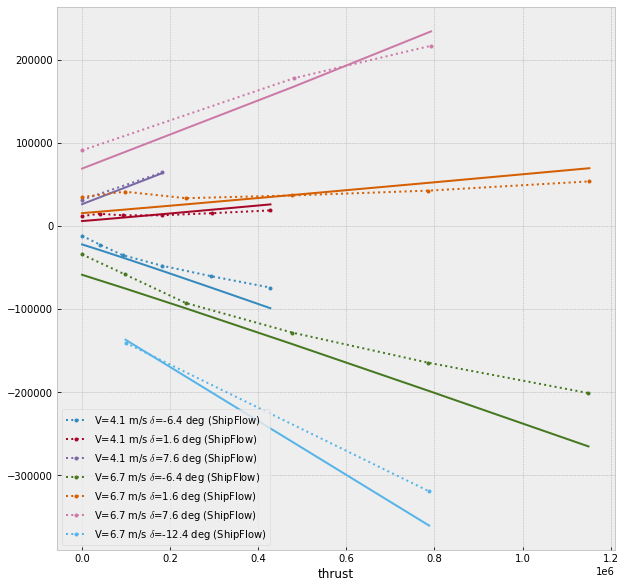

In [41]:
fig,ax=plt.subplots()
fig.set_size_inches(10,10)
df_rudder.sort_values(by=['V','thrust'], inplace=True)

prediction_groups = df2.groupby(by=['V','delta'], sort=False)
key = 'fy_rudders'
for (V_,delta_), group in df_thrust_variation.groupby(by=['V','delta'], sort=False):
    plot = group.plot(x='thrust', y=key, label=f'V={np.round(V_,1)} m/s $\delta$={np.round(np.rad2deg(delta_),1)} deg (ShipFlow)', style='.:', ax=ax)
    color = plot.lines[-1].get_color()
    
    prediction_groups.get_group((V_,delta_)).plot(x='thrust', y=key, label='__none__', color=color, style='-', ax=ax)

ax.legend(loc='lower left')
ax.grid(True)

In [66]:
rho_=1000
Ar_ = shipdict.rudder_particulars[0]['ar']
V_ = df_VCT['V']*0.7
df_VCT['cl'] = df_VCT['fy_rudders']/(1/2*rho_*Ar_*V_**2)

In [67]:
df_rudder_no_thrust = df_VCT.groupby('test type').get_group('Rudder angle resistance (no propeller)').copy()
df_rudder_no_thrust.sort_values(by=['V'], inplace=True)

In [68]:
df3 = replace_with_semiempirical_rudder(df_VCT=df_rudder_no_thrust, C_L_tune_=C_L_tune_, thrust_key=thrust_key)

Text(0, 0.5, 'CL')

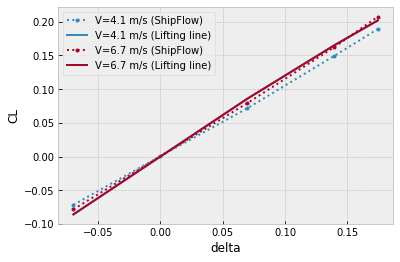

In [69]:
fig,ax=plt.subplots()

prediction_groups = df3.groupby(by='V', sort=False)

rho_=1000
Ar_ = shipdict.rudder_particulars[0]['ar']
V_ = df3['V']*0.7
df3['cl'] = df3['fy_rudders']/(1/2*rho_*Ar_*V_**2)

key = 'cl'
#key = 'fy'
for V_, group in df_rudder_no_thrust.groupby(by='V', sort=False):
    plot = group.plot(x='delta', y=key, label=f'V={np.round(V_,1)} m/s (ShipFlow)', style='.:', ax=ax)
    color = plot.lines[-1].get_color()
    prediction_groups.get_group(V_).plot(x='delta', y=key, label=f'V={np.round(V_,1)} m/s (Lifting line)', color=color, style='-', ax=ax)
    
ax.set_ylabel('CL')